<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">
<b> Комментарий ревьюера</b>
    
Привет! Меня зовут Светлана Носова, я снова буду проверять твой проект :)


Опять **ответы на мои комментарии или доработки по моим рекомендациям попрошу выделить каким-нибудь цветом, кроме трех перечисленных.**
Также я попрошу тебя **не менять и не передвигать мои комментарии**, чтобы при последующей проверке мне было проще ориентироваться.
    
        
<hr>
    
**По проекту:** видно, что стараешься :) В общем, все довольно хорошо. Я написала где что подправить. 
</div>

Я многое поняла в эту итерацию. Можно ещё кое-что улучшить, сабплотс. Но сдаю(сь).

<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">
<b> Комментарий ревьюера 2</b>
    
Не бойся удалять. Удаление можно отменить:
    
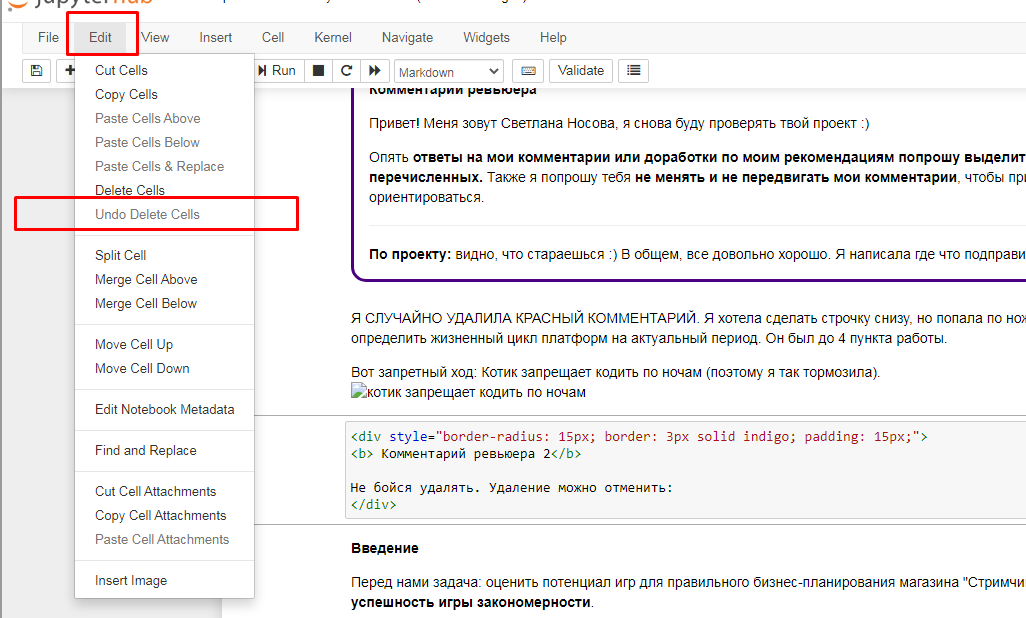
    
   
Я оставила для тебя новые комментарии с цифрой 2.   
</div>

<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">
<b> Комментарий ревьюера 3</b>
    
Ну вот и разобрались :) Работу могу принять. Успехов тебе и терпения :)
</div>

**Введение**

Перед нами задача: оценить потенциал игр для правильного бизнес-планирования магазина "Стримчик". Мы бы хотели выявить **определяющие успешность игры закономерности**.

Данные включают в себя информацию с 1980-х по 2016 гг. В них включена информация о названии игры, жанр дате релиза, платформе релиза, рейтинг, пользовательская оценка, оценка экспертов, а также рейтинг ESRB.

**Актуальным периодом назовём срок с 2012 по 2016 г**. В ходе работы будет подведено основание для выбора такого периода актуальности.

В данных могут быть пробелы разной природы.

Предположительно, визуализация будет исполнена в форме boxplot и гистограмма.

В конце анализа будут проверены две гипотезы о равености массивов с данными до доходности игр для платформы Xbox One и PC, а также -- по жанрам, экшн и спорт. Привлечём библиотеку ```stats```.

Степень отклонения тестовой статистики от нуль-гипотезы - **статистическую значимость или пороговое значение** - оценим в 5% (```alpha = .05```). Критерий значимости позволит отвергнуть или подтвержить нуль-гипотезу. Значение в 5% назначено, поскольку считаем, что ущерб будет не очень значительным. Это всего лишь тарифы, а не здоровье людей.

Поскольку у нас два тарифа, то проверка гипотезы будет двусторонняя. Нулевая гипотеза не будет отвергнута, если $T ⩽ T_0$.


**Оглавление**
- [Предобработка данных](#preprocessing)
- [Исследовательский анализ](#ds)
- [Временные срезы](#periods)
- [Популярность жанров](#genres)
- [Влияние отзывов](#corrs)
- [По регионам](#regions)
- [Проверка гипотез](#hyp)
- [Выводы](#genconcl)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy import stats as st
from functools import reduce

In [2]:
data = pd.read_csv("/datasets/games.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [5]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Наблюдаем: много данных типа float и object.

Два пропуска в названиях, 269 пропусков в годе выпуска (можно оставить nan).
В назаниях: вероятно, случайность, но мб и замена названия. Год: случайность или ещё не вышел.

8578 в описании критиков, 6701 в оценках игроков, 6766 пропусков в рейтинге - можно заменить на 0. Их пока не оценили.


## Предобработка данных
<a id='preprocessing'></a>

In [6]:
#Нам работать с названиями столбцов, лучше убрать завышение. Пробовала как по ссылке, но не вышло
#https://stackoverflow.com/questions/22245171/how-to-lowercase-a-pandas-dataframe-string-column-if-it-has-missing-values
data.set_axis(data.columns.str.lower(),axis=1,inplace=True)
data.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN


<div class="alert alert-success" style="border-radius: 15px">
<b> Комментарий ревьюера</b>
    
А как именно пробовала то, что по ссылке рекомендуют? Я посмотрела, там в основном примеры с одним столбцом. Твой вариант хороший.
</div>

**Буквально 1 раз получилось на данном датасете по всем столбцам! Я оч радовалась** Потом я начала его менять, всё сломалось. Если бы я записала в переменную, то всё сохранилось бы и было бы классно. Но kernel такой kernel.

In [7]:
data['all_sales'] = data[['na_sales', 'eu_sales', 'jp_sales','other_sales']].sum(axis=1)

data.query('user_score == "tbd"').describe()
data.query('user_score == "tbd"')['all_sales'].sum()
tbd_check = pd.DataFrame(data.query('user_score == "tbd"'))
print(tbd_check['platform'].value_counts())
tbd_check.query('year_of_release >= 2016').groupby('platform')['all_sales'].value_counts()

DS      756
Wii     440
GBA     262
PS2     240
XB      150
PSP     123
GC      103
PS3      87
X360     84
3DS      56
PC       49
PS       45
XOne     11
PSV       7
PS4       6
WiiU      5
Name: platform, dtype: int64


platform  all_sales
3DS       0.01         2
          0.02         1
PC        0.01         1
          0.02         1
PS3       0.02         2
          0.05         1
          0.07         1
          0.11         1
          0.17         1
PS4       0.02         3
          0.01         1
          0.03         1
PSV       0.01         1
Wii       0.18         1
WiiU      0.01         1
          0.10         1
          0.19         1
X360      0.04         2
          0.10         2
          0.02         1
XOne      0.01         3
          0.02         3
          0.12         1
          0.12         1
Name: all_sales, dtype: int64

По данным describe пользовательский рейтинг 0 у игр в диапазоне с 1997 по 2016 год. Вкупе они принесли 456 млн дохода.
Но *пока* у них 0 рейтинг. Среди этих игр есть игры платформы DS, Wii, GBA, PS2, XB, PSP, GC. Возможно, до 24 из этих игр, выпущенных в 2016 году, просто не дошли руки.

<div class="alert alert-success" style="border-radius: 15px">
<b> Комментарий ревьюера</b>
    
Можно еще взять метод **sum** с аргументом **axis=1**.
</div>

**Ок, сделала по примеру df['f'] = df[['a','b','c','d']].sum(axis=1) <a href='https://ru.stackoverflow.com/questions/1050010/%D0%A1%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BE%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%BD%D1%8B%D1%85-%D1%81%D1%82%D0%BE%D0%BB%D0%B1%D1%86%D0%BE%D0%B2-%D0%B2-pandas'>отсюда</a>**

In [8]:
#to be determined пока не определён. Ответы мэйл ру, такое, конечно, но пускай. Пока будет 0
print('Нулевой рейтинг у', data['user_score'].isnull().sum())


Нулевой рейтинг у 6701


In [9]:
data.loc[data['user_score'] == "tbd", 'user_score'] = np.nan

In [10]:
data.loc[data['rating'] == "RP"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
13672,Clockwork Empires,PC,NaN,Strategy,0.0,0.04,0.0,0.00,58.0,3.8,RP,0.04
14270,Supreme Ruler: Cold War,PC,2011.0,Strategy,0.0,0.03,0.0,0.01,63.0,6.8,RP,0.04
16180,WRC: FIA World Rally Championship,PC,NaN,Racing,0.0,0.01,0.0,0.00,65.0,NaN,RP,0.01


**Когда ничего не спасает, спасает numpy. Заменила tbd на nan, для наших задач не помешает.**

<div class="alert alert-warning" style="border-radius: 15px">
<b> Комментарий ревьюера</b>
    
В таких заменах главное убедится, что нулей в столбце не было изначально. </div>

In [11]:
data[['critic_score', 'user_score']] = data[['critic_score', 'user_score']].astype('float')

Я за целостность данных, поэтому чтобы работать с nan, надо все перевести во float.

In [12]:
data[['critic_score', 'user_score']] = data[['critic_score', 'user_score']].fillna('0').astype(int)

Есть параметр "рейтинг", его тоже можно оценить:

In [13]:
data['rating'] = data['rating'].fillna('-')
#Замена, правда, породит странности в таблице. Хотелось бы узнать, что у нас вообще по данным рейтинга в части Исследовательский анализ

Популярностью пользуются игры с рейтингом '-' (мы скоро узнаем, почему), «M» («Mature») — «Для взрослых», «E» («Everyone») — «Для всех²», «T» («Teen») — «Подросткам»

In [14]:
data['year_of_release'] = data['year_of_release'].fillna(0)
data['year_of_release'] = data['year_of_release'].astype(int)


In [15]:
data.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,all_sales
count,16715.000000,16715.000000,16715.000000,16715.000000,16715.000000,16715.000000,16715.000000,16715.000000
mean,1974.193599,0.263377,0.145060,0.077617,0.047342,33.574035,3.032665,0.533396
std,252.559930,0.813604,0.503339,0.308853,0.186731,35.818235,3.478856,1.548261
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.000000,0.000000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,70.000000,7.000000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.000000,82.540000


In [16]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Судя до describe(): до 2003 года не было отчётов по странам. с 2007 года появились данные по Америке. С 2010 года есть данные по всем макро-регионам. Посмотрим прицельно.

## Исследовательский анализ данных
<a id='ds'></a>

*Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?*

Данные за все периоды не важны. Просто потому что не велась статистика. Посмотрим по квартилям.

**Определение актуального периода**

In [17]:
print(sorted(data['year_of_release'].unique()))

[0, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


## Временные срезы
<a id='periods'></a>

*За какой характерный срок появляются новые и исчезают старые платформы?*

1. Рост вообще

2. По платформам

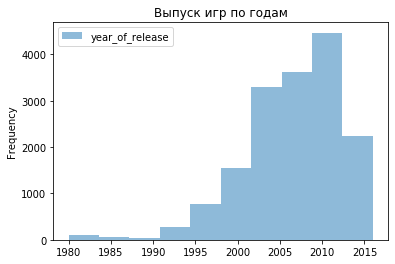

In [18]:
data_years = data[data['year_of_release'] >= 1980.0]['year_of_release'].\
plot(kind='hist', alpha = .5, legend=True).set_title('Выпуск игр по годам')

In [19]:
data_years

Text(0.5, 1, 'Выпуск игр по годам')

В десятилетие с 1980 по 1990 рост игр был очень низким. С 1992 г. по начало 2000-х наблюдался постепенный рост. С 2000 по 2010 гг. - быстрый рост вплоть до пикового значения в пару лет после 2010. Примерно с 2012 по 2015 г. выпуск игр начинает падать.

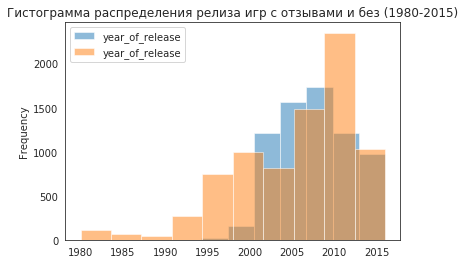

In [135]:
data_fd = data[(data['user_score'] > 0)& (data['critic_score'] > 0) &\
               (data['year_of_release'] > 0)]['year_of_release'].plot(kind='hist', alpha = .5, legend=True).set_title('Гистограмма распределения релиза игр с отзывами и без (1980-2015)')
data_wo_fd = data[(data['user_score'] == 0)&\
                  (data['critic_score']== 0) & (data['year_of_release'] > 0)]['year_of_release'].plot(kind='hist', alpha = .5, legend=True)                                                                                                                

Отзывы критиков наюлюдаются с 1994 года, с 2000 года запрос на отзыв (пользователя или критика) стал расти очень быстро. Игр без отзывов на какое-то время стало меньше, но, возможно, из-за бурного роста игровой индустрии, игр стало больше,чем ревьюеров: с 2010 года отмечается превалирование игр без отзывов над играми с отзывами. К 2015 пропорции сравнялись.

In [136]:
#Отсюда https://stackoverflow.com/questions/51775601/cannot-access-callable-attribute-sort-values-of-dataframegroupby-objects-t
data_platforms = pd.DataFrame(data.groupby(['year_of_release','platform'])['all_sales'].\
sum().sort_values(ascending=False)).reset_index()
data_platforms

,year_of_release,platform,all_sales
0,2004,PS2,211.81
1,2009,Wii,206.97
2,2002,PS2,205.38
3,2003,PS2,184.31
4,2008,Wii,171.32
...,...,...,...
249,1988,PC,0.03
250,1996,PCFX,0.03
251,1994,3DO,0.02
252,2007,DC,0.02


<div class="alert alert-success" style="border-radius: 15px">
<b> Комментарий ревьюера</b>
    
Вот так еще можно:
</div>

Так, видимо, и надо было. Запишу себе комбо .query().pivot_table(). Буду использовать там, где надо собрать боксплот по жанрам.

<div class="alert alert-success" style="border-radius: 15px">
<b> Комментарий ревьюера 2</b>
    
Конечно ты можешь использовать комбо, ведь они выполняются последовательно. 
</div>

<div class="alert alert-danger" style="border-radius: 15px">
<b> Комментарий ревьюера 2</b>
    
По определению актуального периода не было комментария? Никак не могу его найти.. Не суть. С 2007 это очень много. Тут целое поколение сменится. Придут новые приставки, замут рынок и пойдут на спад. Нам нужна свежая информация. Нам нужны свежие пользовательские предпочтения. Учти, что пик продаж по консолям приходится на 3-4 года их жизней. Так что нам не надо отходить далеко от 2017. 
    
Везде далее следует использовать только актуальный период.    
</div>

**Ок**

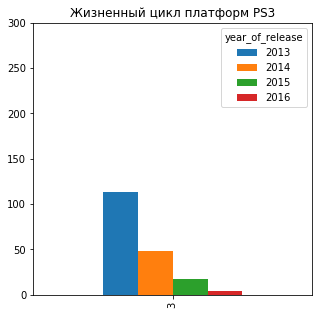

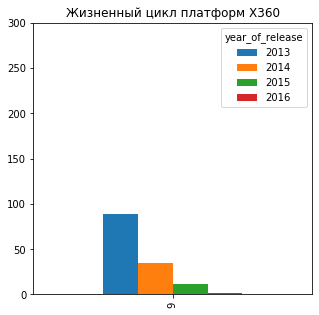

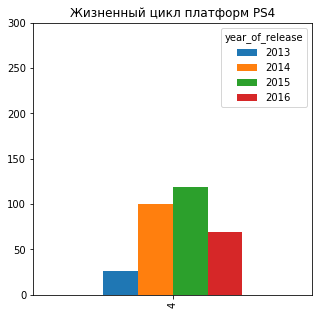

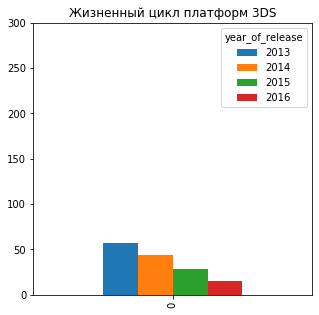

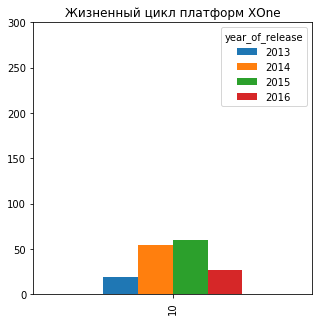

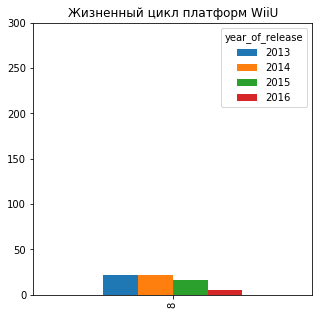

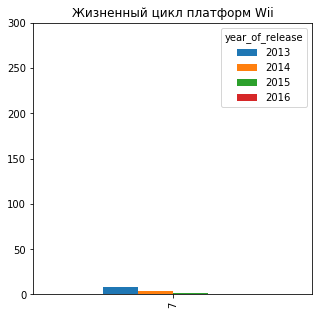

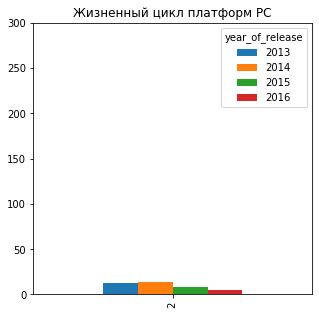

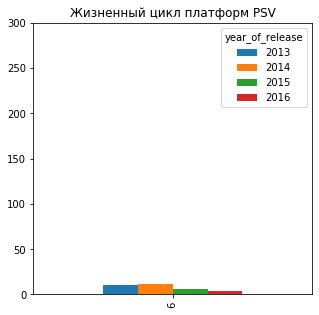

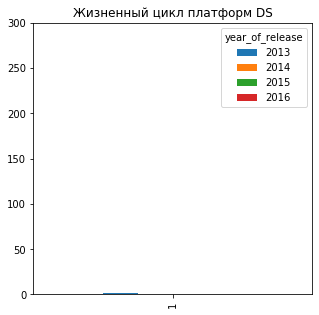

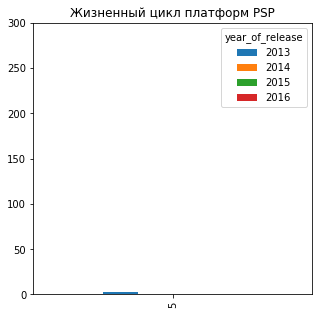

In [22]:
# КОД РЕВЬЮЕРА (был) переделан под нужды. Я пока осваиваю сабплотс
# Я осознала необходимость масштаба. Введен ylim
data.query('year_of_release > 2012').pivot_table(index='platform',\
                                               columns='year_of_release', values='all_sales', aggfunc='sum')
platforms = data.query('year_of_release > 2012')['platform'].unique()
data_life = data.query('year_of_release > 2012 and platform in @platforms').pivot_table(index='platform',\
                                               columns='year_of_release', values='all_sales', aggfunc='sum').reset_index()
for p in platforms:
    data_life[data_life['platform'] == p].plot(kind='bar', figsize=(5,5)).set_title('Жизненный цикл платформ %s' % p)
    plt.ylim(0, 300)

<div class="alert alert-success" style="border-radius: 15px">
<h2> Комментарий ревьюера 3</h2>
    
Так гораздо лучше :)  
</div>

Смешные графики, зато один масштаб. PS3 на спаде. X360 в глубоком спаде. PS4 прошёл пиковую фазу, но ещё очень популярная платформа, продажи есть. 3DS на спаде, но это портативная игровая система, у них должен быть иной жизненный путь. XOne прошёл пиковую стадию, но пока ещё хорош. WiiU на спаде, да и вообще не очень конкурент был. Wii был едва заметен на фоне мастодонтов игровой индустрии, но и так на спаде. PC на фоне остальных тоже не очень (это вообще портативные консоли). DS "не игрок". PSP тоже.

PS4, XOne, PC; Портативные игровые системы: WiiU, Wii, 3DS.

In [23]:

#fig, ax = plt.subplots(3, 4, figsize=(18,9))
#plats = ['3DS', 'DC', 'DS', 'PC', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV', 'Wii',
       #'WiiU', 'X360', 'XB', 'XOne']
#for p in plats:
    #plt.subplot(3, 4, i+1)
    #data_life['p'].plot(kind='bar', sharex=True, ylim=(0, 6))
#plt.show()

**Некоторые платформы на момент выгрузки ещё работают. Мы это ввели в условие.**
    

Text(0.5, 1.0, 'Диапазон размаха продаж по 3-м самым популярным платформам, 2012-2016 гг.')

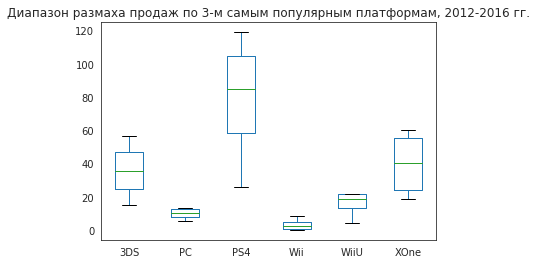

In [80]:
tops = ['PS4', 'XOne', 'PC', '3DS', 'WiiU', 'Wii']
data_top = data.query('year_of_release > 2012 and platform in @tops')[['platform', 'year_of_release', 'all_sales']].\
pivot_table(index='year_of_release', values='all_sales', columns='platform', aggfunc='sum')
data_top.plot(kind='box').set_title('Диапазон размаха продаж по 3-м самым популярным платформам, 2012-2016 гг.')


Свечи у PS4, Xbox One, 3DS - выше и их медианы тоже. PS4 выигрывает по продажам. У обоих нормальное распределение. Продаж у этих монстров игровой индустрии в целом больше. PC меньше (не перекос ли в датасете?)

In [138]:
print(data.columns)
ratings = ['E', '-', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP']
for r in ratings:
    print(r, '-   ', data.loc[data['rating'] == r].count().unique())

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'all_sales'],
      dtype='object')
E -    [3990]
- -    [6764 6766]
M -    [1563]
T -    [2961]
E10+ -    [1420]
K-A -    [3]
AO -    [1]
EC -    [8]
RP -    [3]


## Популярность жанров
<a id='genres'></a>

*Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?*

<div class="alert alert-warning" style="border-radius: 15px">
<b> Комментарий ревьюера</b>

Выведи всю таблицу :)     
</div>

**А, ок. Я буквально поняла задание**

Ниже боксплот с абьюзом возможностей построения графиков. Конда ругается, что я сделала array, не предупредив о типе данных. Но я не знаю, где конкретно исправить тип данных, чтобы numpy не страдал от ошибки. Дескать, сейчас график построился, но когда-нибудь может и не делать этого.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Диапазон разброса по продажам игр разных жанров с 2007 по 2016 г. включительно')

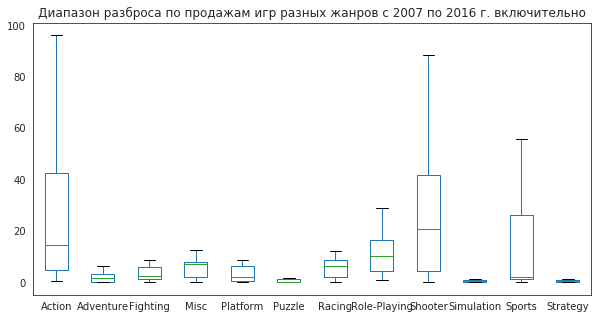

In [139]:
data.query('year_of_release > 2012').pivot_table(index='platform',\
                                                 values='all_sales', columns='genre', aggfunc='sum').\
plot(kind='box', sharex=True, figsize=(10,5), showfliers=False).set_title('Диапазон разброса по продажам игр разных жанров с 2007 по 2016 г. включительно')


Экшн, ролевые игры и спорт (по всем регионам) - более всего продаются и их распределение визиуально нормальное. Ненормальное, но с важным перекосом распределение у стрелялок-шутеров. Продажи растут, но где? Может, в США, где и в реальной жизни оружие можно увидеть часто у гражданских. Популярность жанров зависит от макрорегиона, и мы к этому вернемся ниже.

<div class="alert alert-warning" style="border-radius: 15px">
<b> Комментарий ревьюера</b>
    
Хорошо. А может ли быть такая ситуация, что экшн делает продажи только за счет большего количества игр и большого количества бестселлеров (это можно вдиеть по боксплоту)? Быть может, другие жанры имеют больше продаж в расчете на единицу игры. Сделай то же самое, но с медианными продажами.
    
Здесь и далее нужно будет уже брать актуальный период.    
</div>

In [140]:
#Если смотреть только по срезу, без привлечения диапазона, то нам выпадут следующие данные
data.query('year_of_release > 2012').groupby('genre')['all_sales'].median().sort_values(ascending=False)[:3]

genre
Shooter     0.450
Sports      0.240
Platform    0.225
Name: all_sales, dtype: float64

<div class="alert alert-success" style="border-radius: 15px">
<b> Комментарий ревьюера 2</b>
    
Да, экшн оказался не таким уж и успешным.
</div>

Самые популярные по всем данным с 2012 года: стрелялка, спортивные игры, платформенные.

In [122]:
data.query('year_of_release > 2012').groupby('genre')['all_sales'].median().sort_values(ascending=False)[-3:]

genre
Strategy     0.08
Puzzle       0.06
Adventure    0.03
Name: all_sales, dtype: float64

Наименее выгодный с 2012: приключенческие игры, стратегии, паззлы (игры-загадки).

## Влияние отзывов на продажи
<a id='corrs'></a>

<div class="alert alert-warning" style="border-radius: 15px">
<b> Комментарий ревьюера</b>
    
Откинь здесь нули, на которые были заменены пропуски. И построй лучше точечную диаграмму. Она будет более наглядная. 
</div>

**Точечки! С общим масштабом, но на разных графиках. Объяснение ниже**

<div class="alert alert-warning" style="border-radius: 15px">
<b> Комментарий ревьюера 2</b>
    
У тебя наны на нули зменены же :)
    
Если не ошибаюсь, раньше тут был scatter плот. Верни его, ведь он куда более наглядный в таких делах.
    
</div>

Пользовательская и экспертная оценка используют разные шкалы. Мы разнесём на два скаттерплота.

In [123]:
#bins = data.groupby('platform ')['all_sales'].quantile([0,.05,0.1,0.15,0.20,0.25,0.3,0.35,0.40,0.45,0.5,0.55,0.6,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1]).count()
data_PS3_critic = data.query('platform == "PS4" and year_of_release > 2012 and critic_score !=0').pivot_table(index='critic_score', values = 'all_sales', aggfunc='sum')
data_PS3_user = data.query('platform == "PS4" and year_of_release > 2012 and user_score !=0').pivot_table(index='user_score', values = 'all_sales', aggfunc='sum')

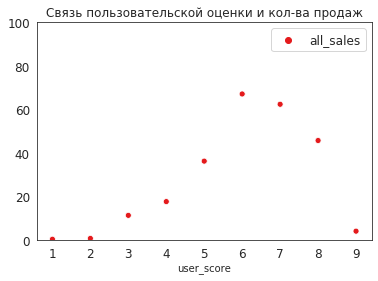

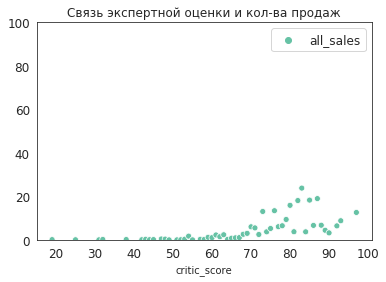

In [124]:
sns.scatterplot(data=data_PS3_user, palette='Set1').set_title("Связь пользовательской оценки на продажи")
sns.set_style("white")
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Связь пользовательской оценки и кол-ва продаж", fontsize=12)
plt.legend(fontsize=12)  
plt.ylim(0, 100)
plt.show()

sns.scatterplot(data=data_PS3_critic, palette='Set2').set_title("Влияние экспертной оценки на продажи")
sns.set_style("white")
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Связь экспертной оценки и кол-ва продаж", fontsize=12)
plt.legend(fontsize=12) 
plt.ylim(0, 100)
plt.show()

Красным отмечены данные по пользовательским ревью, зелёным -- по экспертным. Задана общая шкала по шкале y. У разных видов оценок -- разная диверсификация (у экспертов до 100 баллов, у пользователей - до 9). В анализе отброшены нулевые значения. Совсем никакие игры не учитываются. Игры с пользовательской оценкой в 6 баллов продавались в большем количестве.
Экспертная оценка в 70 баллов - признак наиболее продаваемой игры за изучаемый период.
Но самая высокая оценка -- не признак того, что будет больше продано копий. Возможно, более дизайнерские и дорогие, замечательные с точки зрения игрока и эксперта игры просто стоят дороже.
Попробуем вычислить.

In [125]:
print(data.query('year_of_release > 2012 and platform == "PS4" and user_score !=0')['all_sales'].\
      corr(data.query('year_of_release > 2012 and platform == "PS4" and critic_score !=0')['critic_score']))
print(data.query('year_of_release > 2012 and critic_score !=0')['all_sales'].corr(data.query('year_of_release > 2012 and critic_score !=0')['critic_score']))

0.40589480145836687
0.3136995151027369


In [126]:
print(data.query('year_of_release > 2012 and platform == "PS4" and user_score !=0')['all_sales'].corr(data.query('year_of_release > 2012 and platform == "PS4" and user_score !=0')['user_score']))
print(data.query('year_of_release > 2012 and user_score !=0')['all_sales'].corr(data.query('year_of_release > 2012 and user_score !=0')['user_score']))

-0.027033058622341188
-0.0048345649282943255


По данным положительная корреляция у экспертной оценки. Это произошло из-за того, что эксперты высоко оценили игры-сиквелы. А вот у пользовательской оценки сильный перекос в сторону негативной корреляции из-за высокой оценки в 9 игр, которые не продавались так много.
Из-за каких игр это произошло.

In [127]:
#data.query('platform == "PS3" and year_of_release > 2012 and critic_score !=0').pivot_table(index='platform', values = 'all_sales', columns='critic_score', aggfunc='sum')
data.query('year_of_release > 2012').loc[data['critic_score'] == 97]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8,M,16.27
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8,M,12.62
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97,7,M,5.47


Интереса ради проверили, какие игры получили самую высокую экспертную оценку: Grand Theft Auto. Даже непосвященный в игровую тематику человек может знать эти игры. Эксперты поставили высокие оценки сиквелы очень старых игр, вокруг которых уже сложилась свое сообщество.

In [128]:
data.query('year_of_release > 2012').loc[data['user_score'] == 9]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
110,Mario Kart 8,WiiU,2014,Racing,3.15,2.15,1.28,0.51,88,9,E,7.09
149,The Last of Us,PS3,2013,Action,2.41,2.18,0.28,0.99,95,9,M,5.86
260,Super Mario 3D World,WiiU,2013,Platform,2.11,1.16,0.73,0.32,93,9,E,4.32
303,The Witcher 3: Wild Hunt,PS4,2015,Role-Playing,1.02,2.13,0.23,0.59,92,9,M,3.97
677,The Legend of Zelda: Majora's Mask 3D,3DS,2015,Action,1.15,0.55,0.47,0.17,89,9,E10+,2.34
1499,The Witcher 3: Wild Hunt,XOne,2015,Role-Playing,0.69,0.50,0.00,0.11,91,9,M,1.30
2851,The Witcher 3: Wild Hunt,PC,2015,Role-Playing,0.21,0.46,0.00,0.05,93,9,M,0.72
4771,Metal Gear Solid: The Legacy Collection,PS3,2013,Adventure,0.31,0.01,0.03,0.06,93,9,M,0.41
10707,Steins;Gate,PSV,2013,Adventure,0.04,0.04,0.00,0.02,83,9,M,0.10
10959,Steins;Gate 0,PSV,2015,Adventure,0.00,0.03,0.05,0.01,86,9,M,0.09


Высокая оценка у игр со сравнительно малыми продажами. Кстати, игра Ведьмак тут на двух платформах, но мы сохранили разделение: вторая платформа -- это PC. Игры на платформах-приставках и компьютерных играх делят игроков на два лагеря.

<div class="alert alert-warning" style="border-radius: 15px">
<b> Комментарий ревьюера</b>
    
Тут тоже нули отбрось.
</div>

**Нулей больше нет, есть наны**

**Убирала нули в каждом случае в срезах**

In [129]:
# КОД РЕВЬЮЕРА

# Есть нули
data.head()


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0,-,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0,-,31.38


<div class="alert alert-success" style="border-radius: 15px">
<b> Комментарий ревьюера 2</b>
    
В любом случае, ни нули, ни наны тут не нужны. Они ведь нам статистику могут испортить. Не все алгоритмы хорошо с ними работают. Ну и количество пропусков в разных столбцах может быть разное. 
</div>

##  По регионам

<div class="alert alert-warning" style="border-radius: 15px">
<b> Комментарий ревьюера 2</b>
    
Актуальный период поправь
    :)
</div>

**ok-ok. я вообще не игрок, не в курсе того, как тут всё меняется**

<div class="alert alert-success" style="border-radius: 15px">
<h2> Комментарий ревьюера 3</h2>
    
Тоже не играю. Из здравого смысла пытаюсь соображать :)  
</div>

Ммм, вложённый for) Почему я никак не усвою. Обязательно вкручу в следующий раз, если представится возможность.

In [134]:
# КОД РЕВЬЮЕРА
data_top #тут живые платформы
parameters = ['genre', 'platform', 'rating']
regions = {'na_sales', 'eu_sales', 'jp_sales'}


for region in regions:
    print('\n\nРегион:', region, '\n')
    for param in parameters:
        print('Параметр:', param, '\n')
        display(data.query('year_of_release > 2012 and platform in @data_top').groupby(param)[region].max().sort_values(ascending=False).head(5))
        print('\n')
        



Регион: eu_sales 

Параметр: genre 



genre
Action          6.31
Sports          6.12
Shooter         5.86
Role-Playing    4.19
Racing          2.15
Name: eu_sales, dtype: float64



Параметр: platform 



platform
PS4     6.31
3DS     4.19
XOne    2.19
WiiU    2.15
PC      1.82
Name: eu_sales, dtype: float64



Параметр: rating 



rating
M       6.31
E       6.12
-       5.86
T       2.50
E10+    1.39
Name: eu_sales, dtype: float64





Регион: jp_sales 

Параметр: genre 



genre
Role-Playing    4.35
Action          2.79
Fighting        2.43
Simulation      1.90
Shooter         1.46
Name: jp_sales, dtype: float64



Параметр: platform 



platform
3DS     4.35
WiiU    1.46
PS4     0.49
Wii     0.05
XOne    0.04
Name: jp_sales, dtype: float64



Параметр: rating 



rating
-       4.35
T       2.62
E10+    1.46
E       1.40
M       0.49
Name: jp_sales, dtype: float64





Регион: na_sales 

Параметр: genre 



genre
Shooter         6.03
Role-Playing    5.28
Action          3.96
Fighting        3.27
Racing          3.15
Name: na_sales, dtype: float64



Параметр: platform 



platform
PS4     6.03
3DS     5.28
XOne    4.59
WiiU    3.15
Wii     1.88
Name: na_sales, dtype: float64



Параметр: rating 



rating
-       6.03
M       3.96
E       3.15
T       2.78
E10+    2.49
Name: na_sales, dtype: float64

*Извини, я пыталась освоить subplot, но пока работаю с тем, что есть.*

Популярные жанры различаются по макро-регионам.

Европа -- экшн, рейтинг М, платформа PS4.

США -- шутер, без рейтинга, платформа PS4.

Япония -- ролевые, без рейтинга, платформа 3DS

<div class="alert alert-warning" style="border-radius: 15px">
<b> Комментарий ревьюера</b>
    
Расширь вывод, пожалуйста. Платформы, жанры и рейтинги по регионам. Прокомментируй ситуацию с отсутствующим рейтингом. Почему в Японии так популярен? Не забудь про актуальный период.
</div>

**Вывод в смысле код? Вывод словами -- это конечно.**

<div class="alert alert-success" style="border-radius: 15px">
<h2> Комментарий ревьюера 3</h2>

Да, с играми без рейтинга ситуация интересная. ESRB работает только на территории СА, в Японии есть аналогичная организация: CERO. Я думаю, что, с одной стороны, иностранным играм они не присваивают рейтинги, поскольку на них уже есть маркировка. Чтобы не было конфликта, так сказать. Так что вполне возможно, что часть игр это продукция Японии или же это корейские игры (там тоже своя организация). С другой стороны, раз они продают игры на своем рынке, то присвоение рейтинга может быть обязательным. Значит, дело еще может быть в том, что наша таблица это склейка двух таблиц: продажи на западе и на востоке. Так или иначе, это очень показательный пример, пропуски иногда бывают полезны.
</div>

## Проверка гипотез
<a id='hyp'></a>

<div class="alert alert-warning" style="border-radius: 15px">
<b> Комментарий ревьюера 2</b>
    
здесь тоже актуальный период.
</div>

**ок**

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные **надо переформулировать: Средние пользовательские рейтинги жанров Action и Sports равны**
 

In [131]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [132]:
data.query('year_of_release > 2012 and platform == "PC" and user_score > 0')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
458,The Sims 4,PC,2014,Simulation,1.00,1.82,0.0,0.23,70,3,T,3.05
1095,StarCraft II: Heart of the Swarm,PC,2013,Strategy,0.83,0.66,0.0,0.18,86,7,T,1.67
1351,SimCity (2013),PC,2013,Simulation,0.48,0.77,0.0,0.17,64,2,E10+,1.42
1437,Battlefield 4,PC,2013,Shooter,0.39,0.87,0.0,0.10,81,6,M,1.36
1530,Fallout 4,PC,2015,Role-Playing,0.51,0.67,0.0,0.10,84,5,M,1.28
...,...,...,...,...,...,...,...,...,...,...,...,...
16456,Fallout Anthology,PC,2015,Action,0.00,0.01,0.0,0.00,0,8,-,0.01
16463,TrackMania Turbo,PC,2016,Action,0.00,0.01,0.0,0.00,79,6,E,0.01
16509,Ride 2,PC,2016,Racing,0.00,0.01,0.0,0.00,78,7,E,0.01
16518,Rugby World Cup 2015,PC,2015,Sports,0.00,0.01,0.0,0.00,0,1,E,0.01


<div class="alert alert-warning" style="border-radius: 15px">
<b> Комментарий ревьюера</b>
    
Тут тоже напомню: актуальный период и нули. А еще у тебя опечатка в запросе, отсюда такой результат теста.
</div>

Вижу - исправляюсь

In [137]:
#XOne - это аббревиатура Xbox One
rating_xbox = data.query('year_of_release > 2012 and platform == "XOne" and user_score != 0')['user_score']
rating_pc = data.query('year_of_release > 2012 and platform == "PC" and user_score != 0')['user_score']

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(rating_xbox, rating_pc, equal_var = False)

print('\n')
print('pvalue: {:.2f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу') # Нулевая гипотеза всегда о равенстве. Если p(t) меньше заданного уровня значимости, то нулевая гипотеза отвергается в пользу альтернативной. 
else:
    print('Не получилось отвергнуть нулевую гипотезу') 



pvalue: 0.07
Не получилось отвергнуть нулевую гипотезу


Выборки по платформам не равны.

<div class="alert alert-warning" style="border-radius: 15px">
<b> Комментарий ревьюера</b>
    
Не нужно вызывать **mean** для столбцов. Ведь тогда будет число. Мы в тесте сравниваем выборки, а не числа :)
</div>

**Это случайно**

<div class="alert alert-warning" style="border-radius: 15px">
<b> Комментарий ревьюера</b>
    
Тут тоже период не тот.
</div>

**Исправлено**

In [118]:
rating_action = data.query('year_of_release > 2012 and genre == "Action" and user_score != 0')['user_score']
rating_sports = data.query('year_of_release > 2012 and genre == "Sports" and user_score != 0')['user_score']

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(rating_action, rating_sports, equal_var = False)

print('\n')
print('pvalue: {:.2f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу') # Нулевая гипотеза всегда о равенстве. Если p(t) меньше заданного уровня значимости, то нулевая гипотеза отвергается в пользу альтернативной. 
else:
    print('Не получилось отвергнуть нулевую гипотезу') 



pvalue: 0.00
Отвергаем нулевую гипотезу


Выборки по жанрам равны.

# Выводы
<a id='genconcl'></a>


Мы провели анализ игровых платформ с 1980 по 2016 г. В ходе исследования были выявлены самые перспективные жанры, платформы, в том числе по регионам.
Для целей прогнозирования был использован актуальный период с 2012 года.


В рамках этого периода можно было проследить -- что было сделано -- жизнеспособность игровых платформ (до 7 лет). Спад популярности и продаж мог происходить от 1 до 4 лет.
Наиболее устойчивыми перед непостоянством рынка оказались законодатели мод в игровой индустрии: японские платформы и разработка Майкрософт.
За актуальный период при разделении на макрорегионы: Америка, Европа, Япония  -- выявились черты популярных жанров и платформ
Учитывая содержательные особенности игр по возрастным группам, нелишним отметить, что в макрорегионах разный "возраст" игрока. Данными по Японии мы не располагаем: у них собственная 
В Японии по-видимому свой возрастной ценз по играм.

Мы построили диаграмму рассеяния по глобальным продажам игр в разбивке по "живым" платформам. Среди них и портативные платформы. Среди платформ есть и PC, но, возможно, данных по комп. играм собрано мало. 

Мы попытались выявить корреляцию между продажами между продажами и мнением пользователей и экспертов по популярной платформе. У экспертной оценки есть положительная корреляция, но видимо за счет оценки популярных игр-сиквелов Гэтэа.
У пользовательской оценки произошёл перекос из-за того, что присвоили высокий рейтинг игре, которую продали в малом количестве. Например, Ведьмак. У нас есть подозрение, что данные по РС играм неполные.

Мы также рассмотрели популярность жанров и выявили причину, почему те или иные жанры выходят в топ. Есть наиболее продаваемые игры жанров экшн, спортс и шутер -- у них и продажи больше, распределение нормальное и медиана выше, чем у остальных.

Проанализировав популярность жанров и платформ по макро-регионам (NA, EU, JP), мы составили сборный портрет игрока.
Возрастные категории уточнены по рейтингу ESRB, который не распространяется на Японию, где, видимо, есть свой рейтинг и в силе иная цензура. Внешние источники указывают на то, что у них есть есть своя CERO.

    - Европа -- экшн, рейтинг М, платформа PS4.
    - США -- шутер, без рейтинга, платформа PS4.
    - Япония -- ролевые, без рейтинга, платформа 3DS.
    
Рейтинг также может играть роль в пользу того, чтобы вызвать противоречивый интерес к игре. Возможно, продавец решил не вызывать лишний интерес, если бы присвоил ограничительный рейтинг.

Проверены гипотезы для сравнения выборок по платформам Xbox One и PC и жанрам Экшн и Спортс (одни из самых популярных). Выборки по платформам всё же отличаются. Выборки по жанрам равны.

Для прогнозирования спроса для российского дистрибьютера Стримчик мы бы рекомендовали ориентироваться на американский и европейский опыт и на мастодонтов индустрии - XBox и PC. Учитывая растущую популярность компьютерных игр, не стоит экспериментировать, а делать ставку на популярные жанры.

Для дальнейшего исследования можно рассмотреть, бывают ли сиквелы игр, предыдущие версии которых эксперты высоко оценили.
